In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [57]:
def grid_search_to_df(grid_search_path, n_features_info_path):
    # Contains a list of grid analysis entries and their corresponding RMSEs
    # The grid analysis done on the matrix completion model tested permutations of the hyperparameters available in the mode
    # such as feature number, number of total trees to train, and the number of best trees to use for prediction
    grid_search_df = pd.read_csv(grid_search_path).set_index("full_comparison_name").drop(["Unnamed: 0"], axis=1)
    # n_features_info_df contains information on the number of overlapping viruses between each comparison (source and target table pair tested in grid analysis) 
    n_features_info_df = pd.read_csv(n_features_info_path).set_index('Unnamed: 0')
    comparisons = []
    for i in n_features_info_df.n_features_info:
        _, source, _, target, _, _, _, _, _ = i.split(' ') # Extract relevant information (source and target table names from entry)
        comparison_name = f"{source[:-1]}_to_{target[:-1]}" # Create a name for the comparison which can be used for identifying subsets of grid_search_df
        comparisons.append(comparison_name)
    # grid_per_comparison is a dict containing all the grid search entries corresponding to a comparison (entries will be permutations of hyperparameter settings)
    grid_per_comparison = {comparison: [i for i in grid_search_df.index if comparison in i] for comparison in comparisons}

    # The following code creates a dataframe that can be used to plot the grid analysis for each comparison
    grid_heatmap_per_comparison = dict()
    for comparison in comparisons:
        grid_indices = grid_per_comparison[comparison]
        grid_heatmap_df = pd.DataFrame() # Heatmap of grid analysis results for a comparison (source and target table pair)
        for idx in grid_indices: # Iterate over each entry name from the grid search dataframe
            if "fon" in idx or "hin" in idx:
                source, _, target_p1, target_p2, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') 
            else:
                source, _, target, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') # Extract relevant fields from entry name
            RMSE = grid_search_df.loc[idx, 'RMSE'] # Access the recorded RMSE of the grid analysis entry
            grid_heatmap_df.loc[f'n_features_{n_features}',f'train_trees_{train_trees}_best_trees_{best_trees}'] = RMSE # Save the grid search information to a dataframe that can be plotted as a heatmap
        grid_heatmap_per_comparison[comparison] = grid_heatmap_df
    return grid_heatmap_per_comparison, grid_search_df, n_features_info_df


def plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=12, fs_y=12, exclude_targets = list()):
#     comparisons = [f"{i.split(' ')[1][:-1]}_to_{i.split(' ')[3][:-1]}" for i in n_features_info_df.n_features_info]
    comparisons = list(grid_heatmap_per_comparison.keys())
    source_tables = set([i.split('_')[0] for i in comparisons])
    comparisons_per_source_table = {source_table: list() for source_table in source_tables}
    for comparison in comparisons:
        source_table = comparison.split("_")[0]
        comparisons_per_source_table[source_table].append(comparison)
        
    for source_table in comparisons_per_source_table: 
        curr_comparisons = comparisons_per_source_table[source_table] # Comparisons specific to one source table
        print(curr_comparisons)
        curr_comparisons = [i for i in curr_comparisons if i.split("_to_")[-1] not in exclude_targets]
        nrows = len(curr_comparisons)
        fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(fs_x, fs_y))
        
        for idx, comparison in enumerate(curr_comparisons):
            sns.heatmap(grid_heatmap_per_comparison[comparison], ax=axs[idx])
            target_table = comparison.split("_to_")[-1]
            axs[idx].set_ylabel(target_table)
        
        for i in range(len(curr_comparisons)-1): # Removes x-labels for all except last row
            axs[i].set_xticklabels("")


        fig.suptitle(f"Table {source_table} Grid Analysis")
        fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
        fig.supylabel("Number of features used")
        plt.tight_layout()
        plt.show()
    return

In [3]:
df = pd.read_csv('n_features_info.csv')
df['Source Table'] = [i.split(" ")[1][:-1] for i in df.n_features_info]
df['Target Table'] = [i.split(" ")[3][:-1] for i in df.n_features_info]
df['Overlapping Virus Count'] = [int(i.split(" ")[-1]) for i in df.n_features_info]
df = df.drop(['Unnamed: 0', 'n_features_info', 'Source Table'], axis=1).set_index("Target Table")

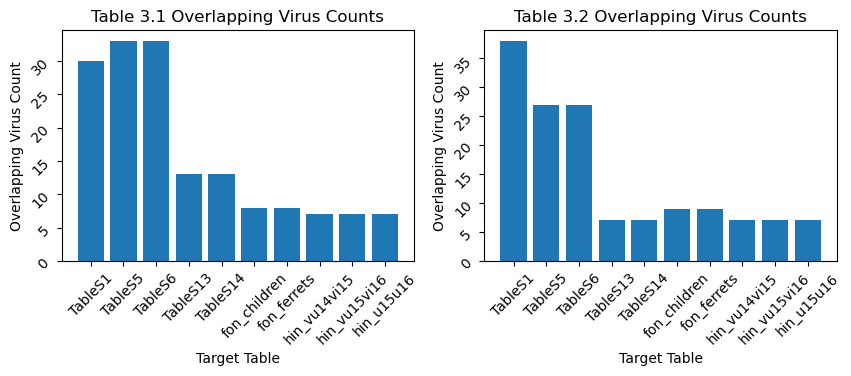

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

axs[0].set_title("Table 3.1 Overlapping Virus Counts")
axs[0].set_xlabel("Target Table")
axs[0].set_ylabel("Overlapping Virus Count")
axs[0].bar(df.index[10:], df['Overlapping Virus Count'][10:])
axs[0].tick_params(labelrotation=45)

axs[1].set_title("Table 3.2 Overlapping Virus Counts")
axs[1].set_xlabel("Target Table")
axs[1].set_ylabel("Overlapping Virus Count")
axs[1].bar(df.index[:10], df['Overlapping Virus Count'][:10])
axs[1].tick_params(labelrotation=45)


In [13]:
n_features_info_df.n_features_info

Unnamed: 0
0     sourceID: TableS3.2, groupID: TableS1, number ...
1     sourceID: TableS3.2, groupID: TableS5, number ...
2     sourceID: TableS3.2, groupID: TableS6, number ...
3     sourceID: TableS3.2, groupID: TableS13, number...
4     sourceID: TableS3.2, groupID: TableS14, number...
5     sourceID: TableS3.2, groupID: fon_children, nu...
6     sourceID: TableS3.2, groupID: fon_ferrets, num...
7     sourceID: TableS3.2, groupID: hin_vu14vi15, nu...
8     sourceID: TableS3.2, groupID: hin_vu15vi16, nu...
9     sourceID: TableS3.2, groupID: hin_u15u16, numb...
10    sourceID: TableS3.1, groupID: TableS1, number ...
11    sourceID: TableS3.1, groupID: TableS5, number ...
12    sourceID: TableS3.1, groupID: TableS6, number ...
13    sourceID: TableS3.1, groupID: TableS13, number...
14    sourceID: TableS3.1, groupID: TableS14, number...
15    sourceID: TableS3.1, groupID: fon_children, nu...
16    sourceID: TableS3.1, groupID: fon_ferrets, num...
17    sourceID: TableS3.1, groupID: h

In [15]:
# Contains a list of grid analysis entries and their corresponding RMSEs
# The grid analysis done on the matrix completion model tested permutations of the hyperparameters available in the mode
# such as feature number, number of total trees to train, and the number of best trees to use for prediction
grid_search_df = pd.read_csv("grid_search_results.csv").set_index("full_comparison_name").drop(["Unnamed: 0"], axis=1)
# n_features_info_df contains information on the number of overlapping viruses between each comparison (source and target table pair tested in grid analysis) 
n_features_info_df = pd.read_csv('n_features_info.csv').set_index('Unnamed: 0')
comparisons = []
for i in n_features_info_df.n_features_info:
    _, source, _, target, _, _, _, _, _ = i.split(' ') # Extract relevant information (source and target table names from entry)
    comparison_name = f"{source[:-1]}_to_{target[:-1]}" # Create a name for the comparison which can be used for identifying subsets of grid_search_df
    comparisons.append(comparison_name)
# grid_per_comparison is a dict containing all the grid search entries corresponding to a comparison (entries will be permutations of hyperparameter settings)
grid_per_comparison = {comparison: [i for i in grid_search_df.index if comparison in i] for comparison in comparisons}

# The following code creates a dataframe that can be used to plot the grid analysis for each comparison
grid_heatmap_per_comparison = dict()
for comparison in comparisons:
    grid_indices = grid_per_comparison[comparison]
    grid_heatmap_df = pd.DataFrame() # Heatmap of grid analysis results for a comparison (source and target table pair)
    for idx in grid_indices: # Iterate over each entry name from the grid search dataframe
        if "fon" in idx or "hin" in idx:
            source, _, target_p1, target_p2, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') 
            
        else:
            source, _, target, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') # Extract relevant fields from entry name
        RMSE = grid_search_df.loc[idx, 'RMSE'] # Access the recorded RMSE of the grid analysis entry
        grid_heatmap_df.loc[f'n_features_{n_features}',f'train_trees_{train_trees}_best_trees_{best_trees}'] = RMSE # Save the grid search information to a dataframe that can be plotted as a heatmap
    grid_heatmap_per_comparison[comparison] = grid_heatmap_df
    

In [46]:
grid_heatmap_per_comparison['TableS3.1_to_TableS1']

,train_trees_10_best_trees_1,train_trees_10_best_trees_3,train_trees_10_best_trees_5,train_trees_10_best_trees_8,train_trees_10_best_trees_10,train_trees_50_best_trees_1,train_trees_50_best_trees_3,train_trees_50_best_trees_5,train_trees_50_best_trees_8,train_trees_50_best_trees_10,...,train_trees_1000_best_trees_5,train_trees_1000_best_trees_8,train_trees_1000_best_trees_10,train_trees_1000_best_trees_20,train_trees_1000_best_trees_50,train_trees_1000_best_trees_100,train_trees_1000_best_trees_200,train_trees_1000_best_trees_300,train_trees_1000_best_trees_500,train_trees_1000_best_trees_750
n_features_5,0.403214,0.366903,0.359139,0.354815,0.353910,0.492978,0.471596,0.469300,0.468265,0.467937,...,0.459282,0.449191,0.447700,0.444633,0.442376,0.441545,0.440186,0.439087,0.438462,0.438225
n_features_10,0.408458,0.370704,0.365448,0.357197,0.355525,0.329876,0.303465,0.295693,0.291118,0.289316,...,0.333223,0.328486,0.328612,0.320080,0.318002,0.316113,0.314735,0.313664,0.311437,0.309759
n_features_15,0.221111,0.192318,0.165795,0.160280,0.160741,0.376670,0.336599,0.332054,0.325168,0.329051,...,0.265450,0.254552,0.255837,0.251066,0.247621,0.245113,0.242667,0.241492,0.239359,0.238560
n_features_20,0.234419,0.195532,0.183716,0.185491,0.182260,0.336596,0.276045,0.272300,0.261864,0.255930,...,0.300807,0.294916,0.292849,0.288954,0.289881,0.291572,0.288626,0.287569,0.287328,0.287322
n_features_25,0.266613,0.211461,0.195040,0.194244,0.196027,0.138563,0.124829,0.120175,0.114737,0.114162,...,0.240954,0.236564,0.232188,0.228908,0.228681,0.225274,0.222936,0.220886,0.219275,0.218619


['TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6', 'TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16']


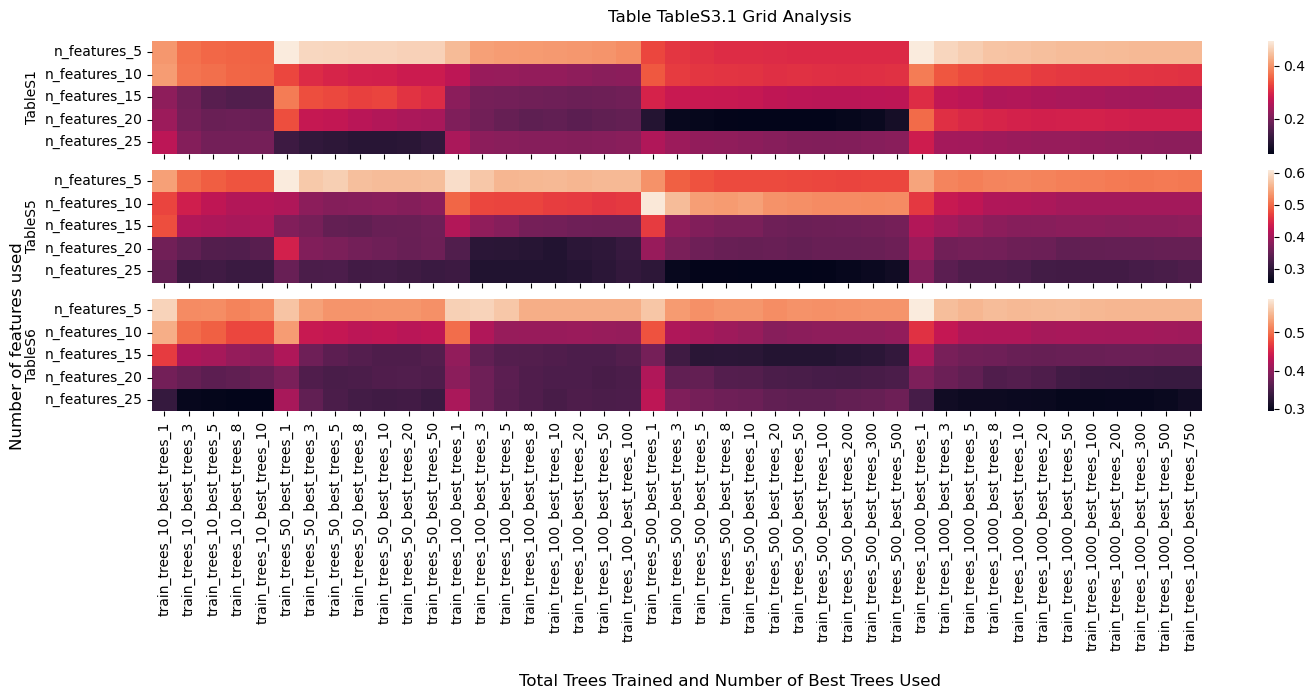

['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6', 'TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16']


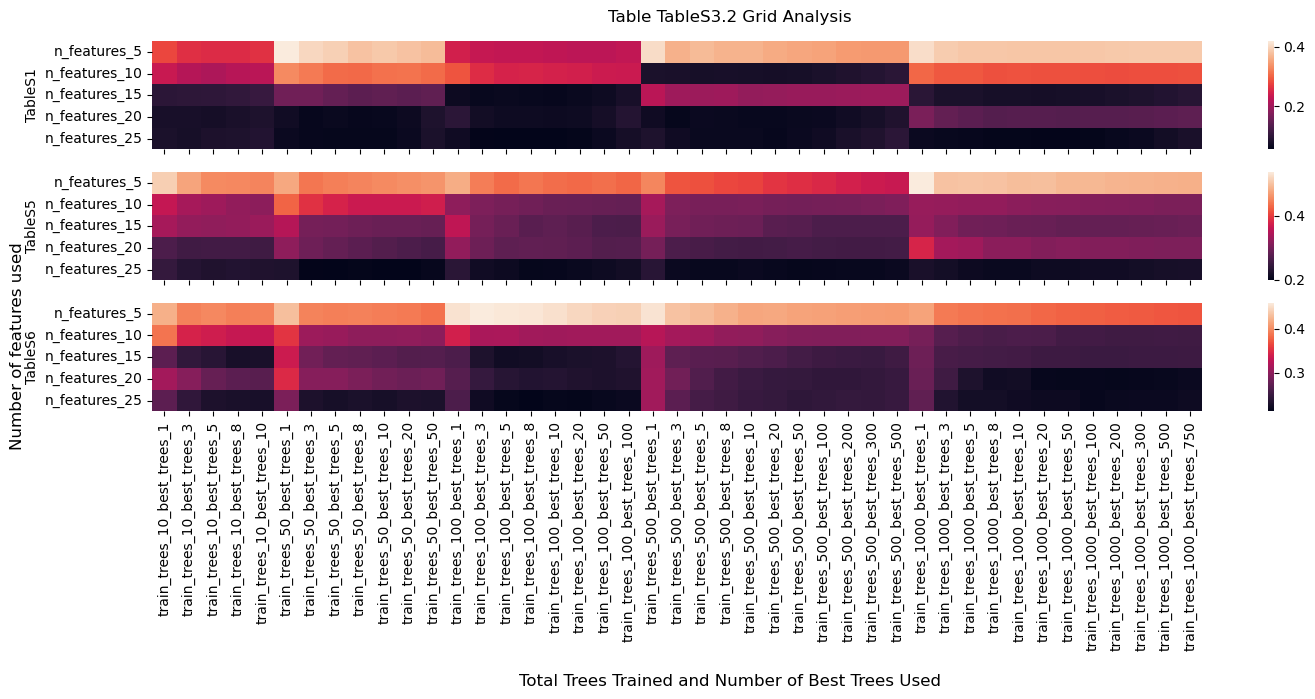

In [61]:
grid_heatmap_per_comparison, grid_search_df, n_features_info_df = grid_search_to_df(grid_search_path='grid_search_results.csv',
                                                                                    n_features_info_path='n_features_info.csv')
plot_grid_search(grid_heatmap_per_comparison, n_features_info_df, fs_x=15, fs_y=7, exclude_targets=['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16'])

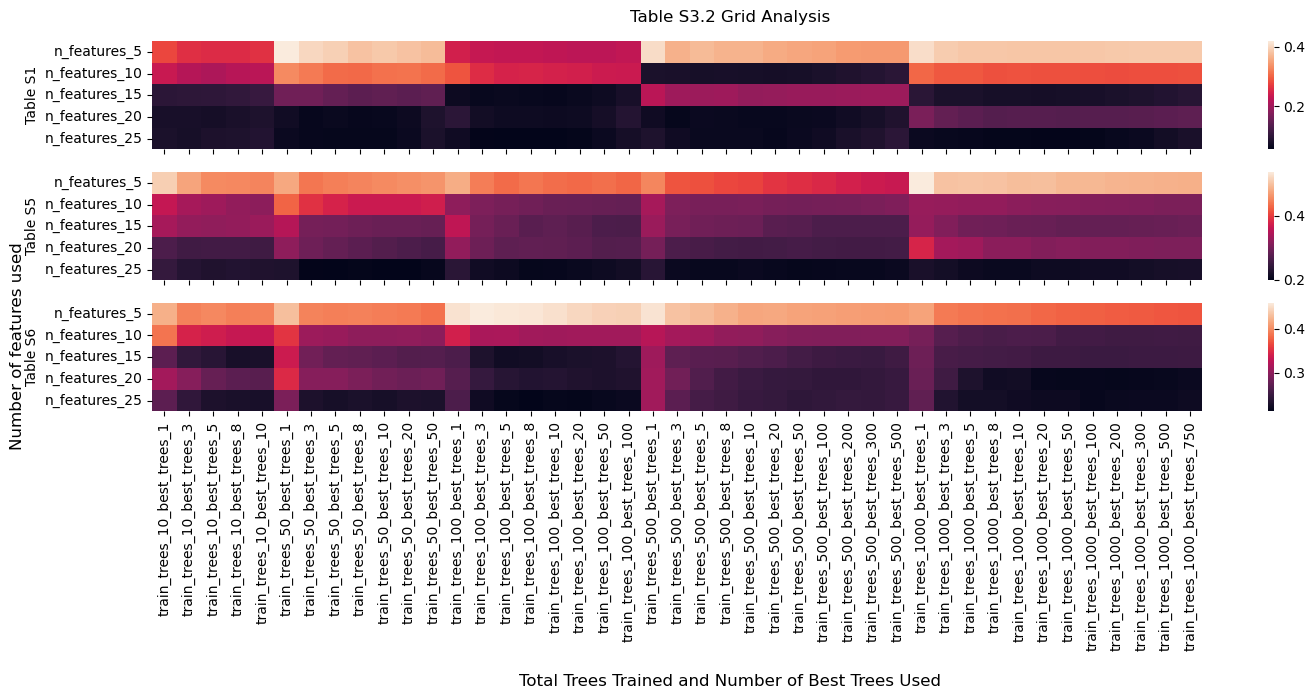

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,7))


sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS1'], ax=axs[0])

sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS5'], ax=axs[1])

sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS6'], ax=axs[2])



axs[0].set_xticklabels("")
axs[1].set_xticklabels("")

axs[0].set_ylabel("Table S1")
axs[1].set_ylabel("Table S5")
axs[2].set_ylabel("Table S6")


fig.suptitle("Table S3.2 Grid Analysis")
fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
fig.supylabel("Number of features used")
plt.tight_layout()
plt.show()

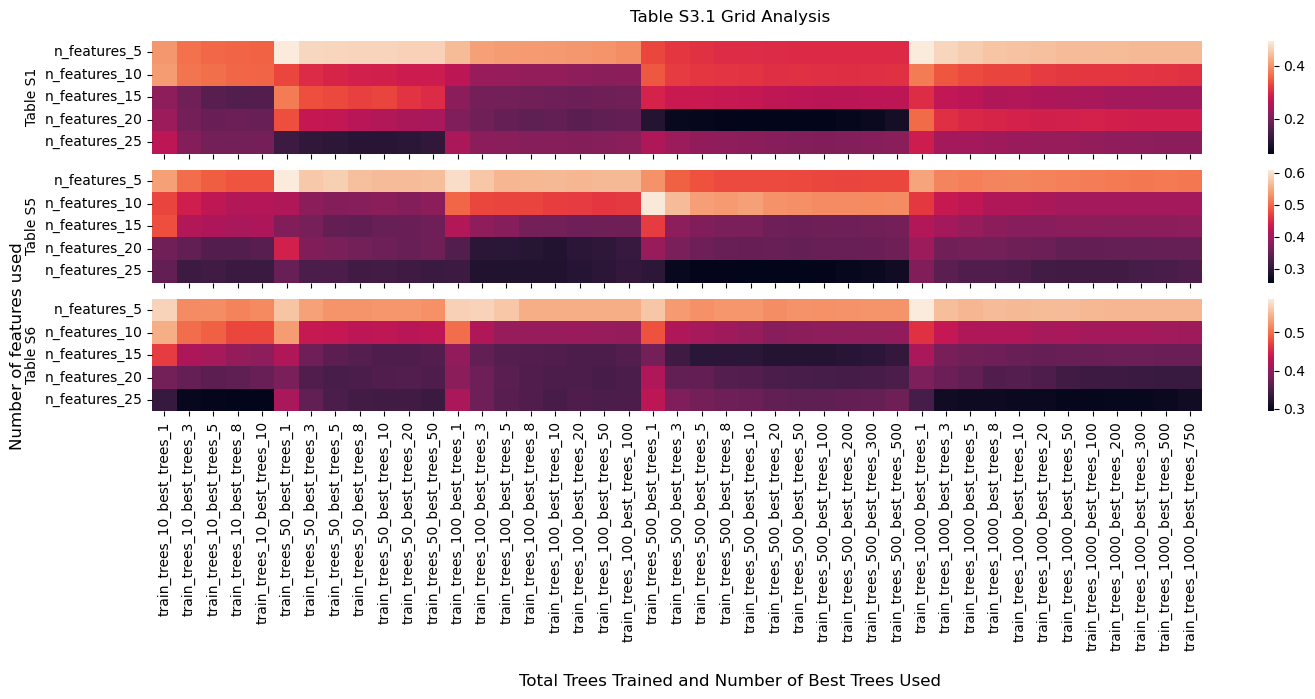

In [182]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,7))


sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS1'], ax=axs[0])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS5'], ax=axs[1])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS6'], ax=axs[2])


axs[0].set_xticklabels("")
axs[1].set_xticklabels("")


axs[0].set_ylabel("Table S1")
axs[1].set_ylabel("Table S5")
axs[2].set_ylabel("Table S6")


fig.suptitle("Table S3.1 Grid Analysis")
fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
fig.supylabel("Number of features used")
plt.tight_layout()
plt.show()

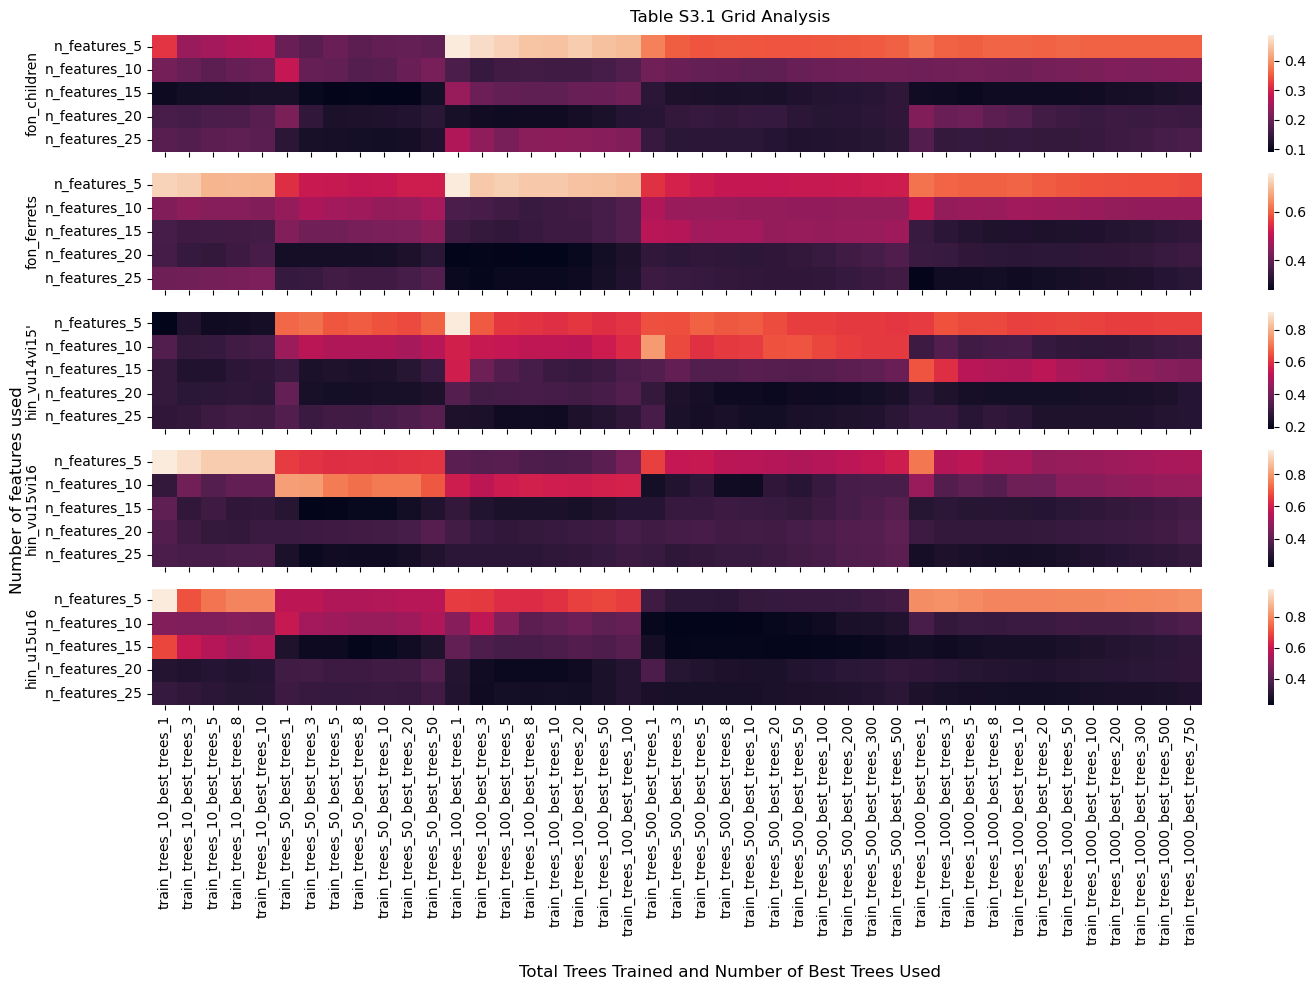

In [100]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,10))


sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_fon_children'], ax=axs[0])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_fon_ferrets'], ax=axs[1])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_hin_vu14vi15'], ax=axs[2])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_hin_vu15vi16'], ax=axs[3])

sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_hin_u15u16'], ax=axs[4])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")

axs[0].set_ylabel("fon_children")
axs[1].set_ylabel("fon_ferrets")
axs[2].set_ylabel("hin_vu14vi15'")
axs[3].set_ylabel("hin_vu15vi16")
axs[4].set_ylabel("hin_u15u16")

fig.suptitle("Table S3.1 Grid Analysis")
fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
fig.supylabel("Number of features used")
plt.tight_layout()
plt.show()

## Secondary Grid Search: Adjusted n_feature values for tables with lower number of viable features to train on

In [37]:
grid_heatmap_per_comparison_secondary.keys()

dict_keys(['TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16', 'TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16'])

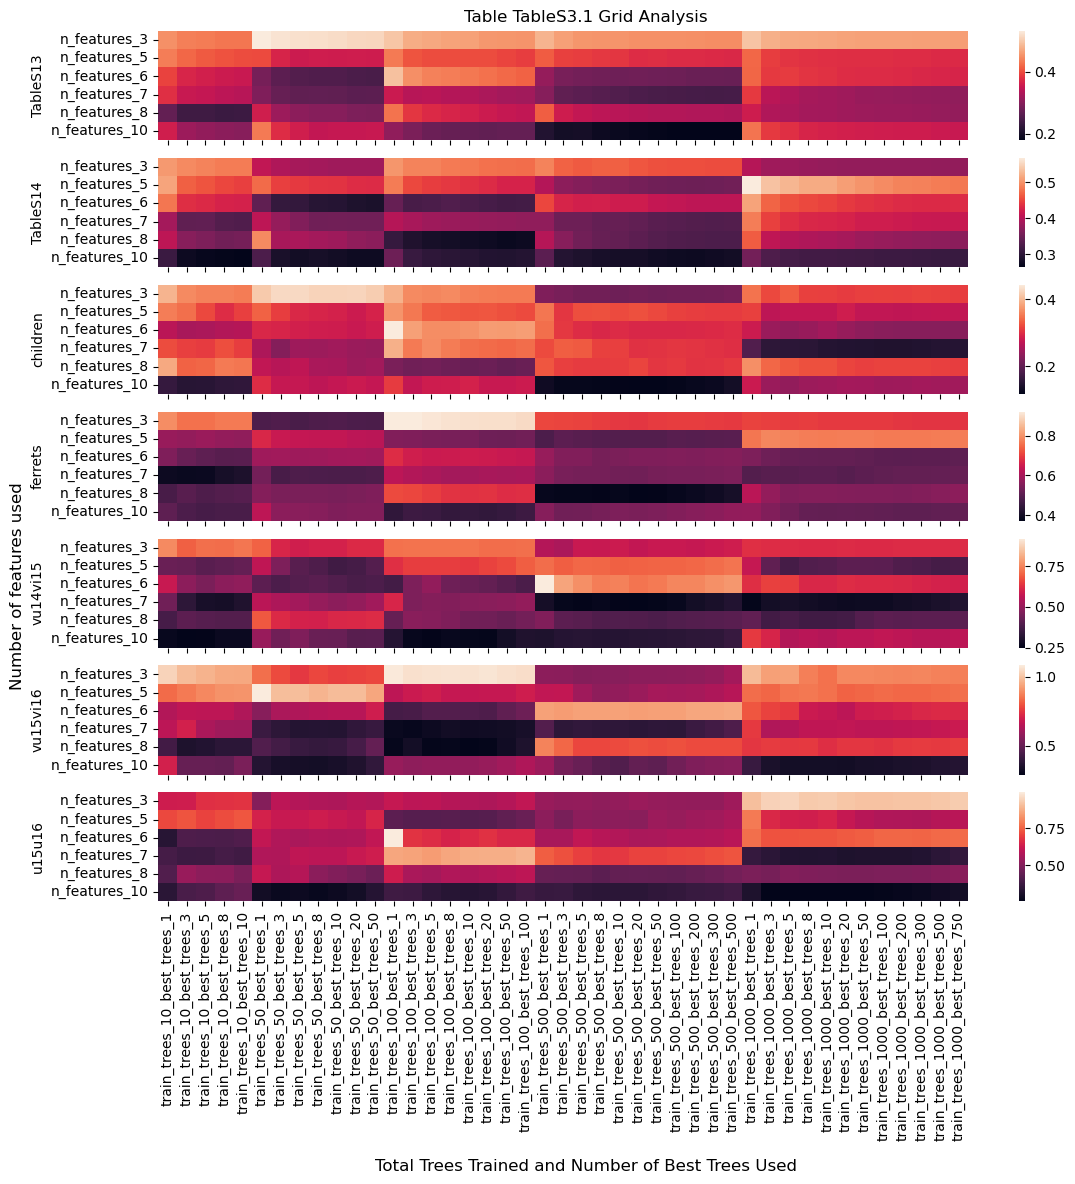

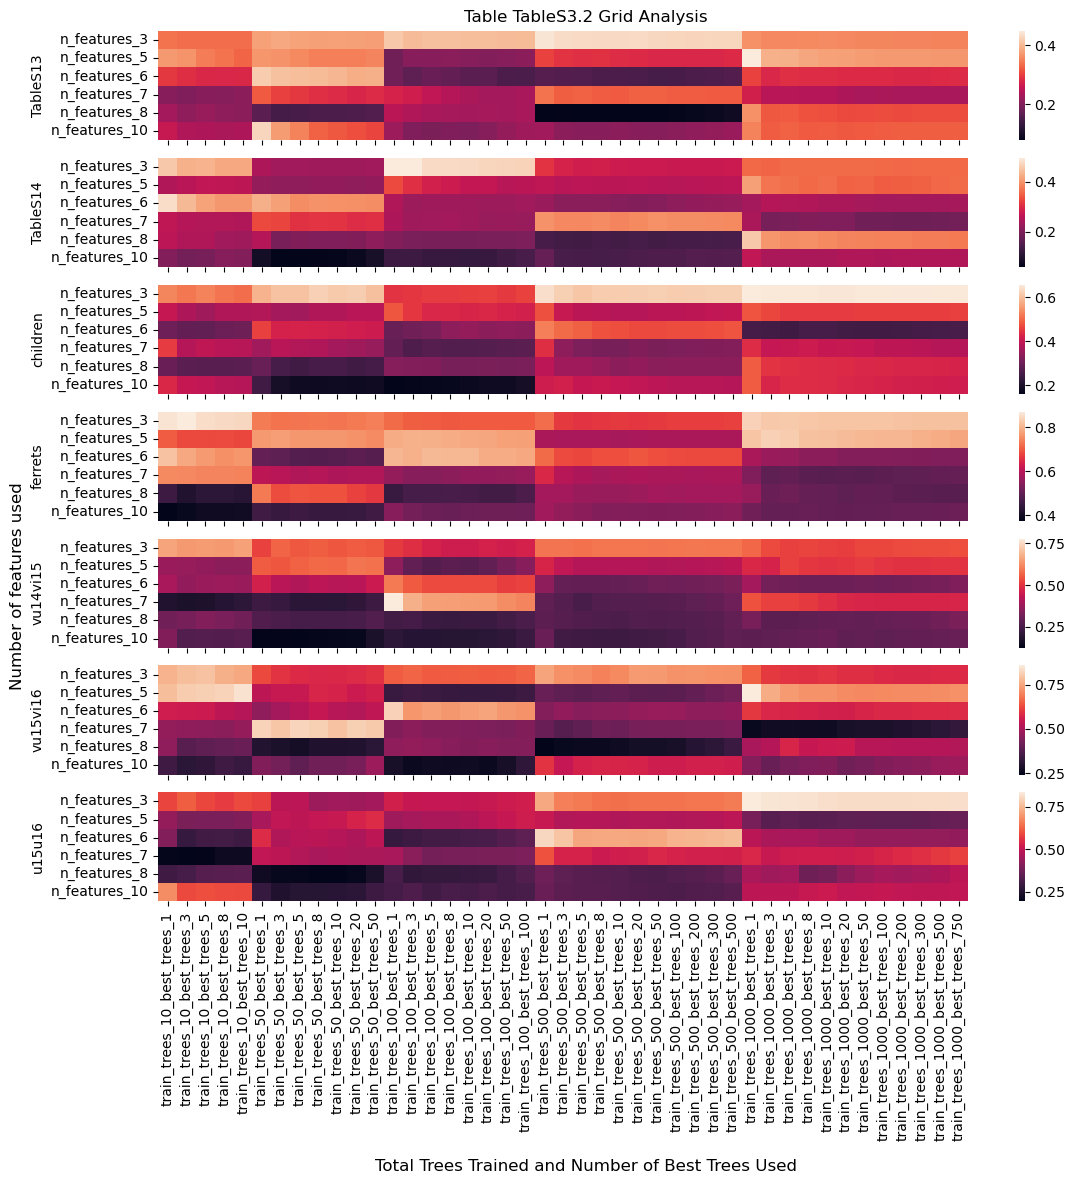

In [21]:
# Contains a list of grid analysis entries and their corresponding RMSEs
# The grid analysis done on the matrix completion model tested permutations of the hyperparameters available in the mode
# such as feature number, number of total trees to train, and the number of best trees to use for prediction
grid_search_secondary_df = pd.read_csv("grid_search_results_secondary.csv").set_index("full_comparison_name").drop(["Unnamed: 0"], axis=1)
# n_features_info_df contains information on the number of overlapping viruses between each comparison (source and target table pair tested in grid analysis) 
n_features_info_secondary_df = pd.read_csv('n_features_info_secondary.csv').set_index('Unnamed: 0')
comparisons_secondary = []
for i in n_features_info_secondary_df.n_features_info:
    _, source, _, target, _, _, _, _, _ = i.split(' ') # Extract relevant information (source and target table names from entry)
    comparison_name = f"{source[:-1]}_to_{target[:-1]}" # Create a name for the comparison which can be used for identifying subsets of grid_search_secondary_df
    comparisons_secondary.append(comparison_name)
# grid_per_comparison_secondary is a dict containing all the grid search entries corresponding to a comparison (entries will be permutations of hyperparameter settings)
grid_per_comparison_secondary = {comparison: [i for i in grid_search_secondary_df.index if comparison in i] for comparison in comparisons_secondary}

# The following code creates a dataframe that can be used to plot the grid analysis for each comparison
grid_heatmap_per_comparison_secondary = dict()
for comparison in comparisons_secondary:
    grid_indices = grid_per_comparison_secondary[comparison]
    grid_heatmap_df = pd.DataFrame() # Heatmap of grid analysis results for a comparison (source and target table pair)
    for idx in grid_indices: # Iterate over each entry name from the grid search dataframe
        if "fon" in idx or "hin" in idx:
            source, _, target_p1, target_p2, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') 
            
        else:
            source, _, target, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') # Extract relevant fields from entry name
        RMSE = grid_search_secondary_df.loc[idx, 'RMSE'] # Access the recorded RMSE of the grid analysis entry
        grid_heatmap_df.loc[f'n_features_{n_features}',f'train_trees_{train_trees}_best_trees_{best_trees}'] = RMSE # Save the grid search information to a dataframe that can be plotted as a heatmap
    grid_heatmap_per_comparison_secondary[comparison] = grid_heatmap_df
    

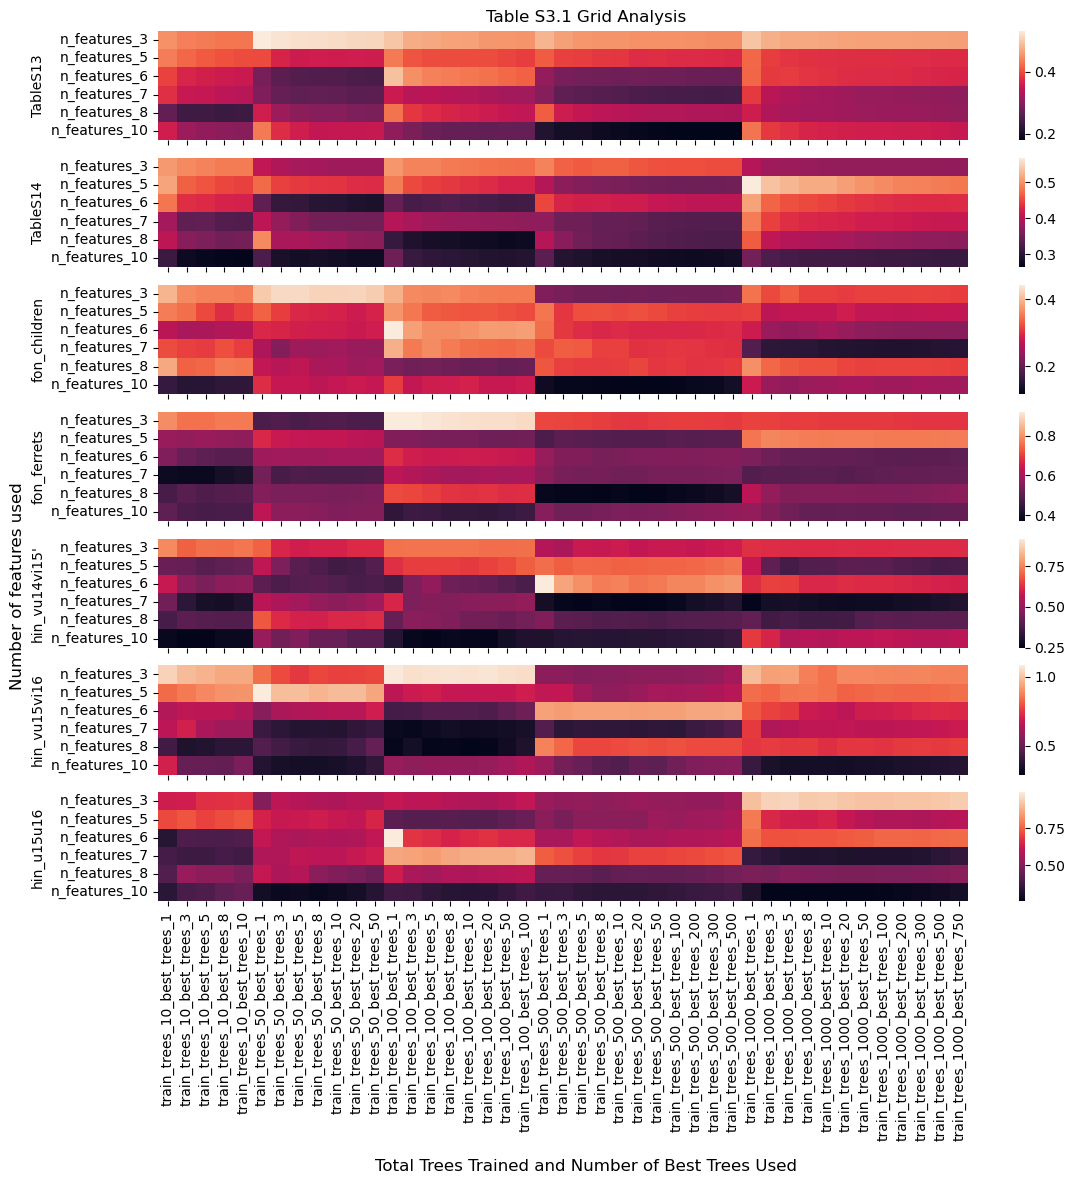

In [177]:
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12,12))

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_TableS13'], ax=axs[0])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_TableS14'], ax=axs[1])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_fon_children'], ax=axs[2])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_fon_ferrets'], ax=axs[3])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_hin_vu14vi15'], ax=axs[4])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_hin_vu15vi16'], ax=axs[5])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.1_to_hin_u15u16'], ax=axs[6])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")
axs[4].set_xticklabels("")
axs[5].set_xticklabels("")

axs[0].set_ylabel("TableS13")
axs[1].set_ylabel("TableS14")
axs[2].set_ylabel("fon_children")
axs[3].set_ylabel("fon_ferrets")
axs[4].set_ylabel("hin_vu14vi15'")
axs[5].set_ylabel("hin_vu15vi16")
axs[6].set_ylabel("hin_u15u16")

fig.suptitle("Table S3.1 Grid Analysis")
fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
fig.supylabel("Number of features used")
plt.tight_layout()
plt.show()

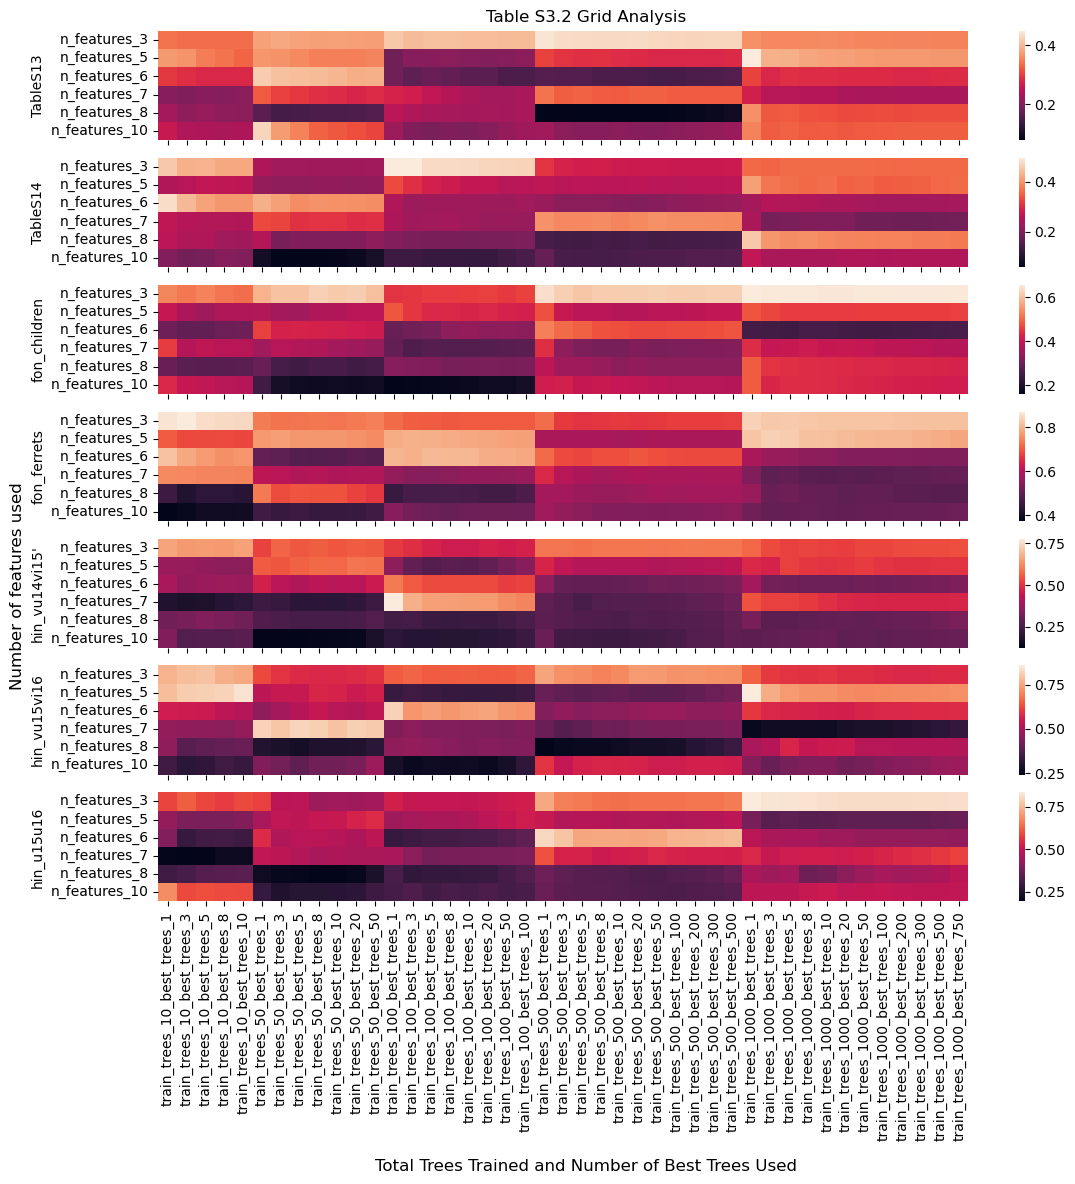

In [184]:
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12,12))

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_TableS13'], ax=axs[0])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_TableS14'], ax=axs[1])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_fon_children'], ax=axs[2])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_fon_ferrets'], ax=axs[3])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_hin_vu14vi15'], ax=axs[4])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_hin_vu15vi16'], ax=axs[5])

sns.heatmap(grid_heatmap_per_comparison_secondary['TableS3.2_to_hin_u15u16'], ax=axs[6])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")
axs[4].set_xticklabels("")
axs[5].set_xticklabels("")

axs[0].set_ylabel("TableS13")
axs[1].set_ylabel("TableS14")
axs[2].set_ylabel("fon_children")
axs[3].set_ylabel("fon_ferrets")
axs[4].set_ylabel("hin_vu14vi15'")
axs[5].set_ylabel("hin_vu15vi16")
axs[6].set_ylabel("hin_u15u16")

fig.suptitle("Table S3.2 Grid Analysis")
fig.supxlabel("Total Trees Trained and Number of Best Trees Used")
fig.supylabel("Number of features used")
plt.tight_layout()
plt.show()

In [38]:
grid_heatmap_per_comparison.keys()

dict_keys(['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6', 'TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16', 'TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6', 'TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16'])

# Grid Search Analysis With and Without Replacement
grid_search_results_highoverlap_withreplacement.csv
grid_search_results_highoverlap_noreplacement.csv
grid_search_results_lowoverlap_withreplacement.csv
grid_search_results_lowoverlap_noreplacement.csv

In [ ]:
grid_search_results_highoverlap_withreplacement